# Final Analysis Visuals

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from geopy.distance import geodesic
from sklearn.cluster import KMeans

In [ ]:
slofood_parquet = pd.read_parquet("slofood_cleaned.parquet")
davisfood_parquet = pd.read_parquet("davisfood_cleaned.parquet")
athensfood_parquet = pd.read_parquet("athensfood_cleaned.parquet")

## Exploratory Visuals

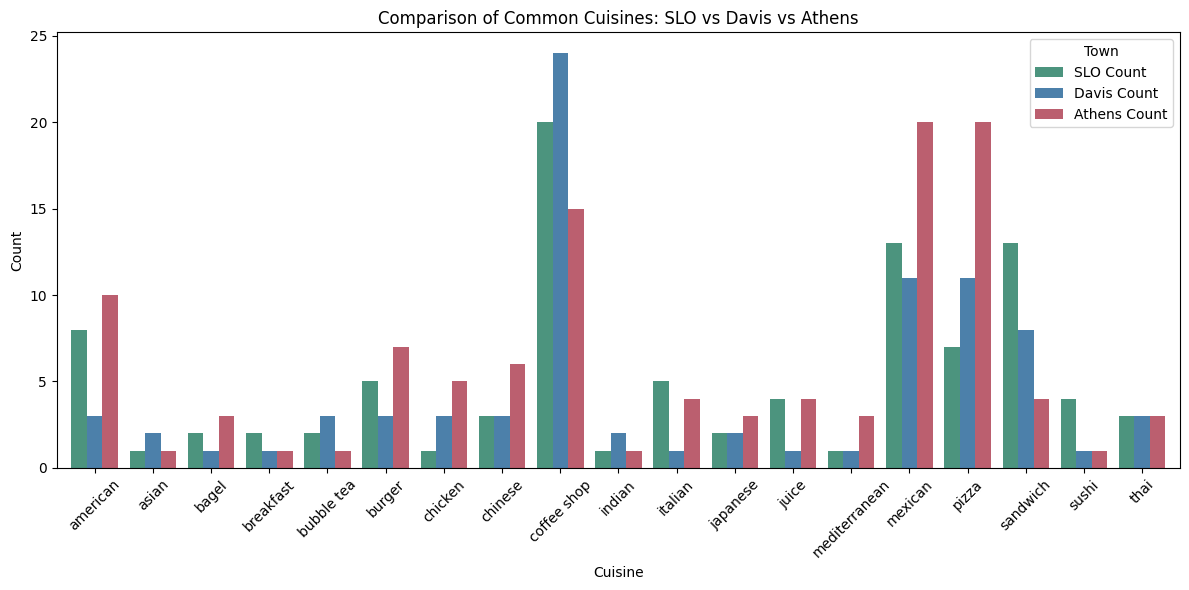

In [3]:
common_cuisines = set(slofood_parquet['cuisine']).intersection(davisfood_parquet['cuisine'], athensfood_parquet['cuisine']) 

slo_cuisine_count = slofood_parquet[slofood_parquet['cuisine'].isin(common_cuisines)].groupby('cuisine').size()
davis_cuisine_count = davisfood_parquet[davisfood_parquet['cuisine'].isin(common_cuisines)].groupby('cuisine').size()
athens_cuisine_count = athensfood_parquet[athensfood_parquet['cuisine'].isin(common_cuisines)].groupby('cuisine').size()

comparison_df = pd.DataFrame({
    'SLO Count': slo_cuisine_count,
    'Davis Count': davis_cuisine_count,
    'Athens Count': athens_cuisine_count
}).fillna(0)

comparison_df.plot(kind='bar', figsize=(12, 6), width=0.8, color=['#006747', '#004B87', '#9E1B32'], alpha=0.7)
plt.title("Comparison of Common Cuisines: SLO vs Davis vs Athens")
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title="Town")
plt.tight_layout()
plt.show()

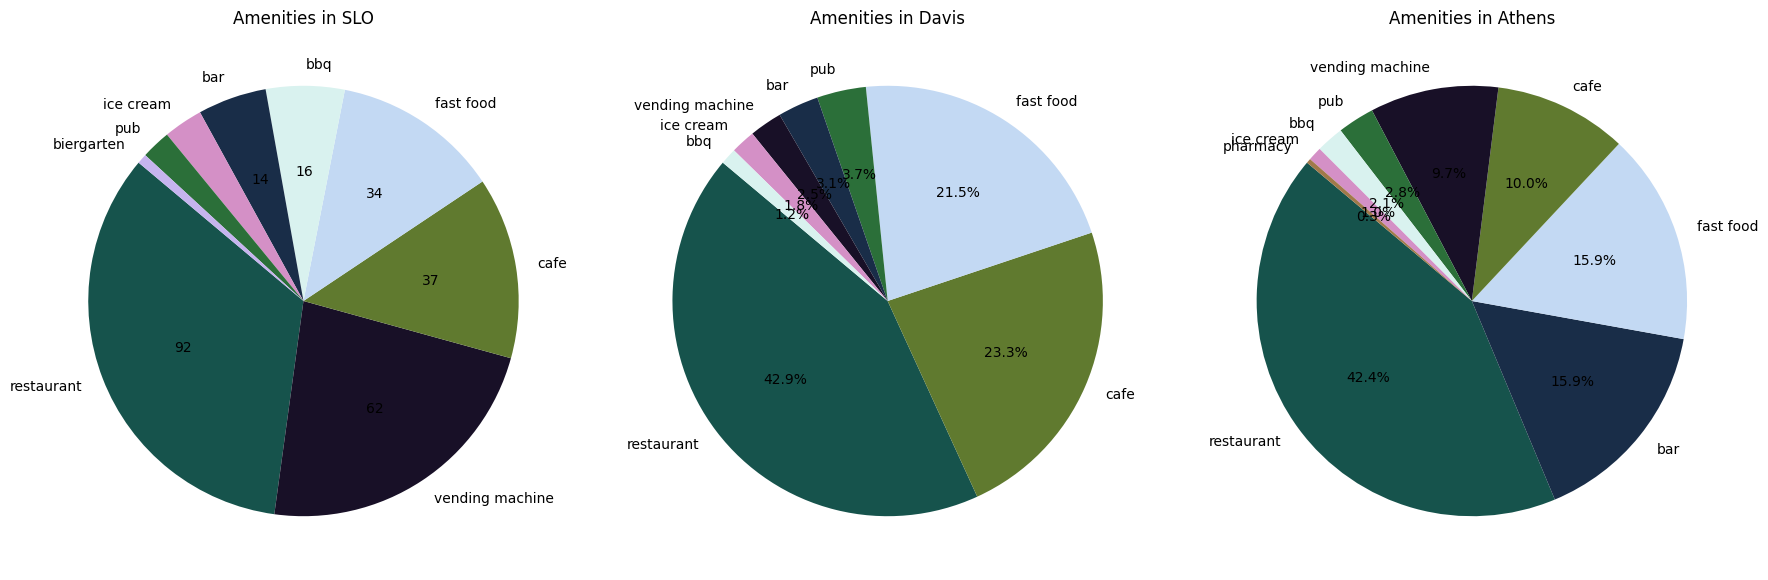

In [4]:
# dont want small percentages to show up 
def autopct_func(pct, allvals):
    absolute = round(pct / 100.*sum(allvals), 0)
    return f"{absolute:.0f}" if pct > 5 else ""  # only show labels for slices > 5%

all_amenities = set(slofood_parquet['amenity']).union(
    set(davisfood_parquet['amenity']), 
    set(athensfood_parquet['amenity'])
)

palette = sns.color_palette("cubehelix", len(all_amenities))  # seaborn color palette
amenity_colors = {amenity: palette[i] for i, amenity in enumerate(all_amenities)}

def get_colors(amenities):
    return [amenity_colors[amenity] for amenity in amenities]  

slo_amenity_counts = slofood_parquet['amenity'].value_counts()
davis_amenity_counts = davisfood_parquet['amenity'].value_counts()
athens_amenity_counts = athensfood_parquet['amenity'].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot SLO amenities
axes[0].pie(slo_amenity_counts, labels=slo_amenity_counts.index, autopct=lambda pct: autopct_func(pct, slo_amenity_counts), 
            startangle=140, colors=get_colors(slo_amenity_counts.index))
axes[0].set_title("Amenities in SLO")

# Plot Davis amenities
axes[1].pie(davis_amenity_counts, labels=davis_amenity_counts.index, autopct='%1.1f%%', 
            startangle=140, colors=get_colors(davis_amenity_counts.index))
axes[1].set_title("Amenities in Davis")

# Plot Athens amenities
axes[2].pie(athens_amenity_counts, labels=athens_amenity_counts.index, autopct='%1.1f%%', 
            startangle=140, colors=get_colors(athens_amenity_counts.index))
axes[2].set_title("Amenities in Athens")

plt.tight_layout()
plt.show()

In the data exploration, I focused on creating visuals to see what the dataset looked like. This included
- distribution of cuisine, amenities, big brands, etc. through bar graphs
- folium/map visuals to see clustering of total food places and specific brands in each town
    - also looked at distance from each place

Some key findings:
- SLO has less unique big brands and different restaurants
- However, SLO has many of the same brand (like 8 Starbucks, for ex)


I want to continue looking at:
- how convient food places are distancewise
- look more into clustering with ML techniques

## Distance Analysis

In [6]:
# university coords
universities = {
    "San Luis Obispo": (35.3004, -120.6625),  # Cal Poly SLO
    "Davis": (38.5449, -121.7405),  # UC Davis
    "Athens": (33.9500, -83.3740)  # University of Georgia
}

# city parquets
city_data = {
    "San Luis Obispo": slofood_parquet,
    "Davis": davisfood_parquet,
    "Athens": athensfood_parquet
}

# folium map for distances from each brand location to its respective university
def map_brand_distance(brand_name):
    
    brand_map = folium.Map(location=[36.5, -100], zoom_start=5)  # center around US (can change for each uni)

    def analyze_brand(city, food_df, brand):

        university_loc = universities[city]
        
        brand_df = food_df[food_df['brand'] == brand]  # filter brand locations
        
        for _, row in brand_df.iterrows():
            brand_loc = (row['lat'], row['lon'])
            distance = geodesic(university_loc, brand_loc).miles
            
            # Mark each location with a popup
            folium.Marker(
                location=brand_loc, 
                popup=f"{brand} in {city}",  
                icon=folium.Icon(color="darkpurple", icon="info-sign")
            ).add_to(brand_map)
            
            # Mark university (only add once per city)
            folium.Marker(
                location=university_loc,
                popup=f"{city} University",
                icon=folium.Icon(color="red", icon="university")
            ).add_to(brand_map)
            
            # Draw line from brand location to university
            folium.PolyLine(
                [university_loc, brand_loc], 
                color="cadetblue", 
                weight=2.5,
                opacity=0.6
            ).add_to(brand_map)

            # Calculate middle point for text label (between university and brand)
            mid_point = [(university_loc[0] + brand_loc[0]) / 2, (university_loc[1] + brand_loc[1]) / 2]
            
            # Add distance label at the midpoint of the line using DivIcon
            folium.Marker(
                location=mid_point,
                icon=folium.DivIcon(
                    html=f'<div style="font-size: 12px; color: black;"><b>{distance:.2f} miles</b></div>'
                )
            ).add_to(brand_map)

            print(f"{brand} in {city} -> {city} University: {distance:.2f} miles")


    # run for all cities
    for city, food_df in city_data.items():
        analyze_brand(city, food_df, brand_name)

    return brand_map


In [7]:
starbucks_map = map_brand_distance('Starbucks')
starbucks_map

Starbucks in San Luis Obispo -> San Luis Obispo University: 3.62 miles
Starbucks in San Luis Obispo -> San Luis Obispo University: 3.70 miles
Starbucks in San Luis Obispo -> San Luis Obispo University: 0.21 miles
Starbucks in San Luis Obispo -> San Luis Obispo University: 0.66 miles
Starbucks in San Luis Obispo -> San Luis Obispo University: 1.34 miles
Starbucks in San Luis Obispo -> San Luis Obispo University: 2.69 miles
Starbucks in San Luis Obispo -> San Luis Obispo University: 0.20 miles
Starbucks in San Luis Obispo -> San Luis Obispo University: 3.55 miles
Starbucks in San Luis Obispo -> San Luis Obispo University: 2.09 miles
Starbucks in San Luis Obispo -> San Luis Obispo University: 1.35 miles
Starbucks in Davis -> Davis University: 2.50 miles
Starbucks in Davis -> Davis University: 1.09 miles
Starbucks in Davis -> Davis University: 1.96 miles
Starbucks in Davis -> Davis University: 0.86 miles
Starbucks in Davis -> Davis University: 8.08 miles
Starbucks in Davis -> Davis Univers

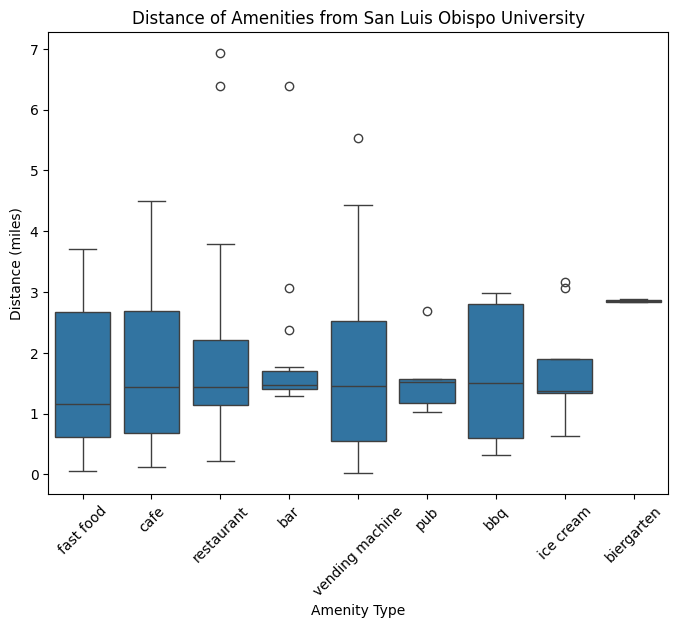

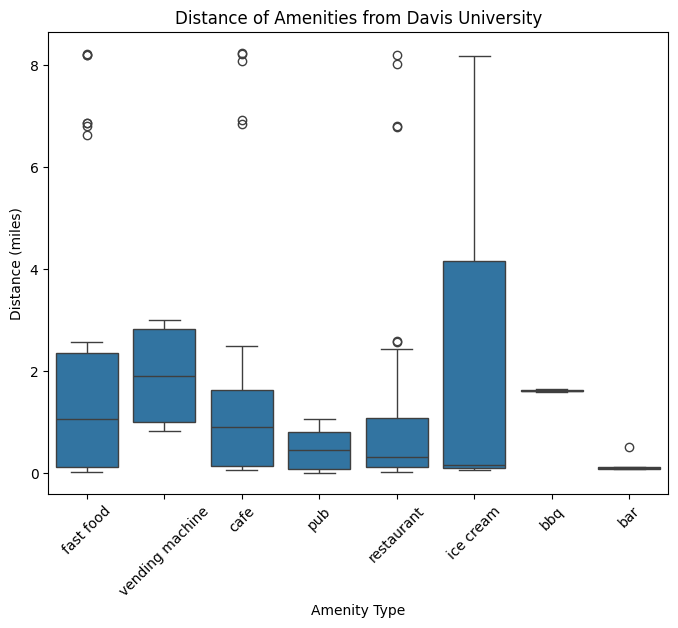

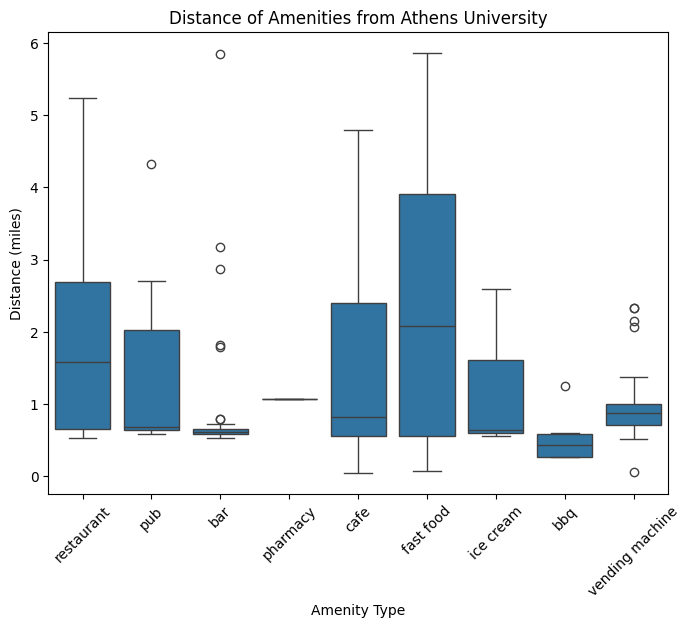

In [8]:
# try boxplots on distances? (not used in final analysis)

def calculate_distance(row, university_loc):
    food_loc = (row['lat'], row['lon'])  # food location coordinates
    distance = geodesic(university_loc, food_loc).miles  # dist in miles
    return distance

# iter through each city and calculate distance
for city, food_df in city_data.items():
    university_loc = universities[city]
    food_df['distance_from_university'] = food_df.apply(lambda row: calculate_distance(row, university_loc), axis=1)

    # box plot for each city
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='amenity', y='distance_from_university', data=food_df)
    
    plt.xticks(rotation=45)
    plt.title(f'Distance of Amenities from {city} University')
    plt.xlabel('Amenity Type')
    plt.ylabel('Distance (miles)')
    
    plt.show()

## ML Clustering Techniques: K-Means Clustering

In [9]:
# apply KMeans clustering and plot on a map

def kmeans_clustering_plot(city, food_df, k=5):

    university_loc = universities[city] # uni location
    
    food_df['distance_from_university'] = food_df.apply(lambda row: calculate_distance(row, university_loc), axis=1) # distance from uni to food
    
    X = food_df[['lat', 'lon']].values  # extract location
    
    # apply K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    food_df['cluster'] = kmeans.fit_predict(X)
    
    folium_map = folium.Map(location=[university_loc[0], university_loc[1]], zoom_start=14) # map around uni
    
    # add markers for each food location, colored by cluster
    colors = ['red', 'blue', 'green', 'purple', 'orange']  # Choose different colors for each cluster
    for _, row in food_df.iterrows():
        folium.CircleMarker(
            location=(row['lat'], row['lon']),
            radius=8,
            color=colors[row['cluster']],
            fill=True,
            fill_color=colors[row['cluster']],
            fill_opacity=0.7,
            popup=f"Amenity: {row['amenity']}<br>Cuisine: {row['cuisine']}<br>Brand: {row['brand']}<br>Cluster: {row['cluster']}"
        ).add_to(folium_map)

    
    # plot university location on the map
    folium.Marker(
        location=[university_loc[0], university_loc[1]],
        popup=f"{city} University",
        icon=folium.Icon(color="red", icon="university")
    ).add_to(folium_map)
    
    # show map
    return folium_map

In [10]:
# run function for each town

for city, food_df in city_data.items():
    folium_map = kmeans_clustering_plot(city, food_df, k=5)  # You can adjust the number of clusters (k)
    folium_map.save(f"{city}_food_clusters.html")  # Save map as HTML file